## Import Module

In [1]:
import argparse
import re
import os, glob, datetime, time
import numpy as np
import easydict
import cv2

import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
import torch.nn.init as init
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from skimage.io import imread, imsave
from sklearn.model_selection import train_test_split

## Define Model Constants

In [26]:
args = easydict.EasyDict({
    "model" : "DnCNN",
    "batch_size" : 64,
    "train_data" : 'Train_set',
    "origin_data" : 'Original_set',
    "epoch" : 100,
    "lr" : 1e-3
})

batch_size = args.batch_size
cuda = torch.cuda.is_available()
n_epoch = args.epoch

save_dir = os.path.join('models', args.model+'_' + 'compression')

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

## Define Data Loader

In [4]:
patch_size, stride = 80, 60
aug_times = 1


class DenoisingDataset(Dataset):
    def __init__(self, ys, xs):
        super(DenoisingDataset, self).__init__()
        self.ys = ys # compression Noisy image
        self.xs = xs # original image
        

    def __getitem__(self, index):
        batch_x = self.xs[index] 
        batch_y = self.ys[index]
        
        return batch_y, batch_x

    def __len__(self):
        return self.xs.size(0)

    
def gen_patches(img):
    patches = []
    h, w = img.shape
    s = 0.8
    h_s, w_s = int(h*s), int(w*s)
    
    img_re = cv2.resize(img, (h_s, w_s), interpolation=cv2.INTER_CUBIC)

    for i in range(0, w_s - patch_size + 1, stride):
            for j in range(0, w_s - patch_size + 1, stride):
                x = img_re[i:i+patch_size, j:j+patch_size]
                patches.append(x)
    
    return patches

    
def datagenerator_noise(data_dir, img_type):
    file_list = glob.glob(data_dir + '/*.' + img_type)
    data = []
    s = 0.8
    
    for i in range(len(file_list)):
        img = cv2.imread(file_list[i], 0)
        h, w = img.shape
        h_s, w_s = int(h*s), int(w*s)
        
        img = cv2.resize(img, (int(h/2), int(w/2)), interpolation = cv2.INTER_AREA) # 이미지 축소
        img = cv2.resize(img, (h, w), interpolation=cv2.INTER_CUBIC) # 이미지 확장
        
        img_re = cv2.resize(img, (w_s, w_s), interpolation=cv2.INTER_CUBIC)
        for j in range(0, w_s - patch_size + 1, stride):
            for k in range(0, w_s - patch_size + 1, stride):
                x = img_re[j:j+patch_size, k:k+patch_size]
                data.append(x)

    data = np.array(data, dtype = 'uint8')
    data = np.expand_dims(data, axis = 3)
    
    return data


def datagenerator_original(data_dir, img_type):
    file_list = glob.glob(data_dir + '/*.' + img_type)
    data = []
    s = 0.8
    
    for i in range(len(file_list)):
        img = cv2.imread(file_list[i], 0)
        h, w = img.shape
        h_s, w_s = int(h*s), int(w*s)
        
        img_re = cv2.resize(img, (w_s, w_s), interpolation=cv2.INTER_CUBIC)
        for j in range(0, w_s - patch_size + 1, stride):
            for k in range(0, w_s - patch_size + 1, stride):
                x = img_re[j:j+patch_size, k:k+patch_size]
                data.append(x)
    
    data = np.array(data, dtype = 'uint8')
    data = np.expand_dims(data, axis = 3)
    
    return data

## Define DnCNN Model

In [5]:
class DnCNN(nn.Module):
    
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        self.depth = depth
        
        self.conv_relu_layers = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True),
            nn.ReLU(inplace=True)
        )

        self.conv_bn_relu_layers = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95),
            nn.ReLU(inplace=True)
        )
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False)
        )

        self._initialize_weights()

    def forward(self, x):
        
        y = x
        
        out = self.conv_relu_layers(x)
        
        for _ in range(self.depth - 2):
            out = self.conv_bn_relu_layers(out)
        
        out = self.conv_layers(out)
        
        return y - out

    
    def _initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

## Define Function of Utility

In [6]:
def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir, 'model_*.pth'))
    if file_list:
        epochs_exist = []
        for file_ in file_list:
            result = re.findall(".*model_(.*).pth.*", file_)
            epochs_exist.append(int(result[0]))
        initial_epoch = max(epochs_exist)
    else:
        initial_epoch = 0
    return initial_epoch


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)

        
def save_result(result, path, ext):
    path = path
    ext = ext
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.clip(result, 0, 1))

## Import Noise Dataset, Original Dataset & Split Training Set, Validation Set

In [7]:
noise_dataset = datagenerator_noise(args.train_data, 'png')
noise_dataset = noise_dataset.astype('float32')/255.0
noise_dataset = torch.from_numpy(noise_dataset.transpose((0, 3, 1, 2)))
    
target_dataset = datagenerator_original(args.origin_data, 'jpg')
target_dataset = target_dataset.astype('float32')/255.0
target_dataset = torch.from_numpy(target_dataset.transpose((0, 3, 1, 2)))


train_dataset, valid_dataset, train_target, valid_target = train_test_split(noise_dataset, target_dataset, test_size = 0.3)


train_target = train_target.numpy()
train_target = torch.from_numpy(train_target.transpose((0, 1, 3, 2)))


valid_target = valid_target.numpy()
valid_target = torch.from_numpy(valid_target.transpose((0, 1, 3, 2)))
    
Train_Dataset = DenoisingDataset(train_dataset, train_target)
DLoader = DataLoader(dataset = Train_Dataset, num_workers = 4, batch_size = batch_size, shuffle = True)

    
Validation_Dataset = DenoisingDataset(valid_dataset, vaild_target)
VLoader = DataLoader(dataset = Validation_Dataset, num_workers = 4)

In [8]:
# Dataset Shape Check
noise_dataset.shape, target_dataset.shape, train_dataset.shape, train_target.shape, vaild_dataset.shape, vaild_target.shape

(torch.Size([35840, 1, 80, 80]),
 torch.Size([35840, 1, 80, 80]),
 torch.Size([25088, 1, 80, 80]),
 torch.Size([25088, 1, 80, 80]),
 torch.Size([10752, 1, 80, 80]),
 torch.Size([10752, 1, 80, 80]))

## Train Model

In [ ]:
print('===> Building model')
model = DnCNN()
    
initial_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
    
if initial_epoch > 0:
    print('resuming by loading epoch %03d' % initial_epoch)
    model = torch.load(os.path.join(save_dir, 'model_%03d.pth' % initial_epoch))
    
    
criterion = nn.MSELoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.2)  # learning rates
    
psnr = []
ssim = []
train_loss = []
valid_loss = []


for epoch in range(initial_epoch, n_epoch):

    model.train()
        
    if cuda:
        model = model.cuda()
        
    psnr_epoch = []
    ssim_epoch = []

    scheduler.step(epoch)  # step to the learning rate in this epcoh
    epoch_loss = 0
    vloss = 0
    count = 0
    start_time = time.time()

    for n_count, batch_yx in enumerate(DLoader):
                
        optimizer.zero_grad()
                
        if cuda:
            batch_y, batch_x = batch_yx[0].cuda(), batch_yx[1].cuda()
            device = torch.device("cuda")
                
        torch.cuda.empty_cache()
        denoising = model(batch_y)
                
        loss = criterion(denoising, batch_x)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if n_count % 10 == 0:
            print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, train_dataset.size(0)//batch_size, loss.item()/batch_size))
        
        denoising = denoising.cpu()
        denoising = denoising.detach().numpy().astype(np.float32)
        
        batch_x = batch_x.cpu()
        batch_x = batch_x.detach().numpy().astype(np.float32)
        
        psnr_train = compare_psnr(batch_x, denoising, data_range = 2)
        #ssim_train = compare_ssim(batch_x, denoising, data_range = 2)
                
        psnr_epoch.append(psnr_train)
        #ssim_epoch.append(ssim_train)
        
    psnr.append(np.mean(psnr_epoch))
    #ssim.append(np.mean(ssim_epoch))
    elapsed_time = time.time() - start_time

    np.savetxt('train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
    torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))
    
    torch.cuda.empty_cache()
    model.eval()
    
    with torch.no_grad():
        for y, x in VLoader:
            y = y.to(device)
            x = x.to(device)
            vloss += criterion(model(y), x)
            count+=1
    valid_loss.append(vloss/count)
    
    train_loss.append(epoch_loss/n_count)
    
    log('epoch = %4d , loss = %4.4f , validation loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, vloss/count, elapsed_time))
    
    save_result(psnr, path=os.path.join('Train_results', 'psnr_results.txt'), ext = '.txt')
    save_result(valid_loss, path=os.path.join('Train_results', 'valid_loss_results.txt'), ext = '.txt')
    save_result(train_loss, path=os.path.join('Train_results', 'train_loss_results.txt'), ext = '.txt')

===> Building model
init weight
init weight
init weight
resuming by loading epoch 075


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

  76    0 /  392 loss = 0.0011
  76   10 /  392 loss = 0.0010
  76   20 /  392 loss = 0.0010
  76   30 /  392 loss = 0.0010
  76   40 /  392 loss = 0.0010
  76   50 /  392 loss = 0.0009
  76   60 /  392 loss = 0.0010
  76   70 /  392 loss = 0.0012
  76   80 /  392 loss = 0.0011
  76   90 /  392 loss = 0.0009
  76  100 /  392 loss = 0.0011
  76  110 /  392 loss = 0.0011
  76  120 /  392 loss = 0.0009
  76  130 /  392 loss = 0.0010
  76  140 /  392 loss = 0.0011
  76  150 /  392 loss = 0.0011
  76  160 /  392 loss = 0.0008
  76  170 /  392 loss = 0.0009
  76  180 /  392 loss = 0.0009
  76  190 /  392 loss = 0.0010
  76  200 /  392 loss = 0.0010
  76  210 /  392 loss = 0.0009
  76  220 /  392 loss = 0.0010
  76  230 /  392 loss = 0.0010
  76  240 /  392 loss = 0.0011
  76  250 /  392 loss = 0.0010
  76  260 /  392 loss = 0.0011
  76  270 /  392 loss = 0.0009
  76  280 /  392 loss = 0.0010
  76  290 /  392 loss = 0.0009
  76  300 /  392 loss = 0.0012
  76  310 /  392 loss = 0.0010
  76  32

## Plot Train Loss and Validation Loss

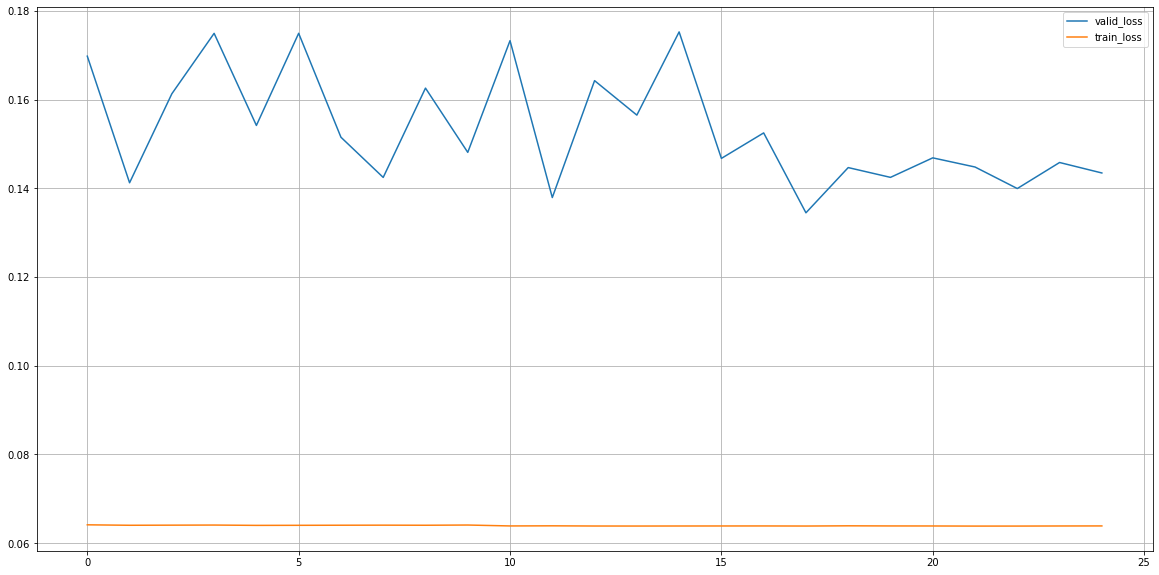

In [25]:
import matplotlib.pyplot as plt
x = np.arange(0, len(valid_loss))
plt.figure(figsize = (20, 10))
plt.plot(x, valid_loss, x, train_loss)
plt.grid()
plt.legend(('valid_loss', 'train_loss'))

## Define Model Test Constants

In [19]:
def parse_args():

    args = easydict.EasyDict({
    "model_dir" : os.path.join('models', 'DnCNN_compression'),
    "Noise_set_dir" : 'Test_set/Test_set(Noise)',
    "Original_set_dir" : 'Test_set/Test_set(Original)',
    "model_name" : 'model_048.pth',
    "result_dir" : 'results',
    "save_result" : 1
    })
    return args

## Model Test and Save Test Result

In [20]:
args = parse_args()
device = torch.device("cuda")

if not os.path.exists(os.path.join(args.model_dir, args.model_name)):
    model = torch.load(os.path.join(args.model_dir, 'model.pth'))
    log('load trained model on Train400 dataset by kai')
else:
    model = torch.load(os.path.join(args.model_dir, args.model_name))
    log('load trained model')

model.eval()

if torch.cuda.is_available():
    model = model.cuda()

if not os.path.exists(args.result_dir):
    os.mkdir(args.result_dir)

test_psnrs = []
test_ssims = []

N_img_list = glob.glob(args.Noise_set_dir + '/*.png')
O_img_list = glob.glob(args.Original_set_dir + '/*.jpg')

for i in range(0, len(N_img_list)):
    if len(N_img_list) == len(O_img_list):
        
        y = np.array(cv2.imread(N_img_list[i], 0), dtype=np.float32)/255.0
        y = y.astype(np.float32)
        y_noise = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])
        
        x = np.array(cv2.imread(O_img_list[i], 0), dtype=np.float32)/255.0
    
        torch.cuda.synchronize()
        start_time = time.time()
        
        y_noise = y_noise.to(device)
        denoising = model(y_noise)
        denoising = denoising.view(y.shape[0], y.shape[1])
        denoising = denoising.cpu()
        denoising = denoising.detach().numpy().astype(np.float32)
    
        torch.cuda.synchronize()
        elapsed_time = time.time() - start_time
        print('%d epoch : %2.4f second' % (i + 1, elapsed_time))
    
        psnr_denoising = compare_psnr(x, denoising, data_range = 2)
        ssim_denoising = compare_ssim(x, denoising)
    
        if args.save_result:
            save_result(denoising, path = os.path.join('results', 'Compression_Denoising_Image_Result', str(i) + 'DnCNN_img.png'), ext = '.png')
    
        test_psnrs.append(psnr_denoising)
        test_ssims.append(ssim_denoising)

test_psnr_avg = np.mean(test_psnrs)
test_ssim_avg = np.mean(test_ssims)

test_psnrs.append(test_psnr_avg)
test_ssims.append(test_ssim_avg)

if args.save_result:
    save_result(test_psnrs, path=os.path.join('results', 'Compression_Denoising_Text_Result', 'psnr_results.txt'), ext = '.txt')
    save_result(test_ssims, path=os.path.join('results', 'Compression_Denoising_Text_Result', 'ssim_results.txt'), ext = '.txt')

log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format('Compression Noisy Image', test_psnr_avg, test_ssim_avg))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2021-12-16 06:10:25: load trained model
1 epoch : 0.1289 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2 epoch : 0.1226 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3 epoch : 0.0906 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4 epoch : 0.0835 second
5 epoch : 0.0807 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


6 epoch : 0.0784 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


7 epoch : 0.0787 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


8 epoch : 0.0786 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


9 epoch : 0.0784 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


10 epoch : 0.0883 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


11 epoch : 0.0876 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


12 epoch : 0.0877 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


13 epoch : 0.0827 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


14 epoch : 0.0811 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


15 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


16 epoch : 0.0813 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


17 epoch : 0.1088 second
18 epoch : 0.0883 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


19 epoch : 0.0827 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


20 epoch : 0.0827 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


21 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


22 epoch : 0.0816 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


23 epoch : 0.0811 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


24 epoch : 0.0855 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


25 epoch : 0.1033 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


26 epoch : 0.0906 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


27 epoch : 0.0835 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


28 epoch : 0.0834 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


29 epoch : 0.0835 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


30 epoch : 0.0811 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31 epoch : 0.0811 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


32 epoch : 0.0815 second
33 epoch : 0.0817 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


34 epoch : 0.0760 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


35 epoch : 0.0754 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


36 epoch : 0.0757 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


37 epoch : 0.0758 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


38 epoch : 0.0861 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


39 epoch : 0.0819 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


40 epoch : 0.0804 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


41 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


42 epoch : 0.0806 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


43 epoch : 0.0855 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


44 epoch : 0.0905 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


45 epoch : 0.0835 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


46 epoch : 0.0813 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


47 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


48 epoch : 0.0814 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


49 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


50 epoch : 0.1052 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


51 epoch : 0.0868 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


52 epoch : 0.0818 second
53 epoch : 0.0815 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


54 epoch : 0.0809 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


55 epoch : 0.0804 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


56 epoch : 0.0805 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


57 epoch : 0.0923 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


58 epoch : 0.0970 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


59 epoch : 0.0851 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


60 epoch : 0.0850 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


61 epoch : 0.0818 second
62 epoch : 0.0798 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


63 epoch : 0.0800 second
64 epoch : 0.0779 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


65 epoch : 0.0747 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


66 epoch : 0.0755 second
67 epoch : 0.0745 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


68 epoch : 0.0744 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


69 epoch : 0.0745 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


70 epoch : 0.0846 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


71 epoch : 0.0948 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


72 epoch : 0.0842 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


73 epoch : 0.0820 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


74 epoch : 0.0805 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


75 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


76 epoch : 0.0804 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


77 epoch : 0.0810 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


78 epoch : 0.0861 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


79 epoch : 0.0819 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


80 epoch : 0.0820 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


81 epoch : 0.0807 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


82 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


83 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


84 epoch : 0.0807 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


85 epoch : 0.0805 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


86 epoch : 0.0850 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


87 epoch : 0.0825 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


88 epoch : 0.0815 second
89 epoch : 0.0795 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


90 epoch : 0.0772 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


91 epoch : 0.0769 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


92 epoch : 0.0775 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


93 epoch : 0.0786 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


94 epoch : 0.0938 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


95 epoch : 0.0843 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


96 epoch : 0.0843 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


97 epoch : 0.0843 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


98 epoch : 0.0820 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


99 epoch : 0.0819 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


100 epoch : 0.0819 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


101 epoch : 0.0815 second
102 epoch : 0.0819 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


103 epoch : 0.0736 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


104 epoch : 0.0735 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


105 epoch : 0.0734 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


106 epoch : 0.0736 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


107 epoch : 0.0791 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


108 epoch : 0.0814 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


109 epoch : 0.0853 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


110 epoch : 0.0815 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


111 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


112 epoch : 0.0816 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


113 epoch : 0.0811 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


114 epoch : 0.0814 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


115 epoch : 0.0867 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


116 epoch : 0.0819 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


117 epoch : 0.0821 second
118 epoch : 0.0818 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


119 epoch : 0.0813 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


120 epoch : 0.0810 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


121 epoch : 0.0805 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


122 epoch : 0.0863 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


123 epoch : 0.0817 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


124 epoch : 0.0811 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


125 epoch : 0.0814 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


126 epoch : 0.0916 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


127 epoch : 0.0835 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


128 epoch : 0.0812 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


129 epoch : 0.0817 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


130 epoch : 0.0823 second
131 epoch : 0.0809 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


132 epoch : 0.0748 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


133 epoch : 0.0743 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


134 epoch : 0.0735 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


135 epoch : 0.0905 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


136 epoch : 0.0826 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


137 epoch : 0.0811 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


138 epoch : 0.0813 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


139 epoch : 0.0811 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


140 epoch : 0.0815 second
2021-12-16 06:11:25: Datset: Compression Noisy Image 
  PSNR = 16.90dB, SSIM = 0.3953
